In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
os.getcwd()
os.chdir("/home/mbilkis/OneDrive/digital-brain/RESEARCH/Sindy/")
from numerics.utilities.misc import *
import matplotlib.pyplot as plt 
from numba import jit
from integration.integrate import *
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import solve_continuous_are


import os
import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint


In [5]:
device = torch.device("cpu")#""
true_A = torch.tensor([[-1.0,2.0],[-2.0, -1.0]]).to(device)
true_y0 = torch.tensor([[2.,0.]]).to(device)

data_size = 1000
batch_size = 10
batch_time = 20

times = torch.linspace(0,10,data_size)

In [6]:
class Lambda(nn.Module):
    def forward(self, t, y):
        return torch.mm(y, true_A)

with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, times, method='euler')
#plt.plot(times.cpu().squeeze(),true_y.cpu().squeeze())


In [7]:

class ODEFunc(nn.Module):

    def __init__(self,latent_dim=2,nhidden=20):
        super(ODEFunc, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y ):
        return self.net(y)
        
        
def get_batch(func,batch_time = 10, batch_size = 20):
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    #batch_y0 = func(s)
    batch_t = times[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

#batch_y0, batch_t, batch_y = get_batch()
#bb = torch.unsqueeze(batch_y0,-1)
#pred_y = odeint(func, batch_y0, batch_t).to(device)
#batch_y0, batch_t, batch_y = get_batch(func)

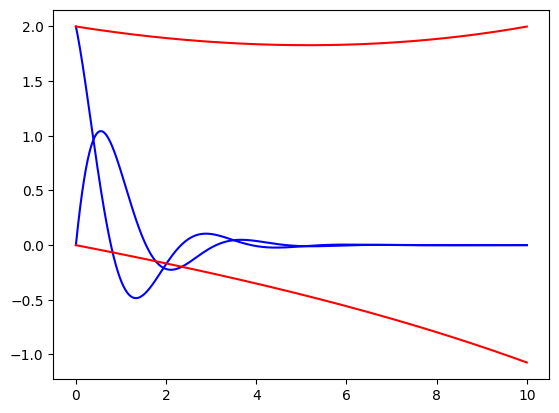

In [9]:
torch.manual_seed(0)
func = ODEFunc().to(device)

pred_y = odeint(func, true_y0, times,method="euler")
plt.plot(times.cpu().squeeze(),true_y.cpu().squeeze(), color="blue")
plt.plot(times.cpu().squeeze(),pred_y.detach().numpy().squeeze(), color="red")

In [16]:
torch.manual_seed(0)
func = ODEFunc().to(device)
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

history = {}
history["losses"] = []
history["params"] = [k.detach().numpy() for k in list(func.parameters())]
history["gradients"] = []


for itr in tqdm(range(1, 1000)):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(func,batch_size=10, batch_time=20)
    pred_y = odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))#/torch.sum(torch.abs(batch_y)))
    loss.backward()
    optimizer.step()

    if itr % 10 == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, times)
            loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            history["losses"].append(loss.item())
            history["params"].append([k.detach().numpy() for k in list(func.parameters())])
            history["gradients"].append([k.grad for k in list(func.parameters())])
    end = time.time()


  2%|██                                                                                                          | 19/999 [00:00<00:25, 37.84it/s]

Iter 0010 | Total Loss 0.610764


  2%|██▌                                                                                                         | 24/999 [00:00<00:32, 29.65it/s]

Iter 0020 | Total Loss 0.452620


  4%|███▉                                                                                                        | 36/999 [00:01<00:29, 32.35it/s]

Iter 0030 | Total Loss 0.378822


  5%|████▊                                                                                                       | 45/999 [00:01<00:32, 29.79it/s]

Iter 0040 | Total Loss 0.284701


  6%|█████▉                                                                                                      | 55/999 [00:01<00:32, 28.95it/s]

Iter 0050 | Total Loss 0.218001


  7%|███████                                                                                                     | 65/999 [00:02<00:33, 27.89it/s]

Iter 0060 | Total Loss 0.178610


  8%|████████                                                                                                    | 75/999 [00:02<00:35, 26.30it/s]

Iter 0070 | Total Loss 0.128186


  9%|█████████▏                                                                                                  | 85/999 [00:03<00:36, 25.28it/s]

Iter 0080 | Total Loss 0.096410


 10%|██████████▎                                                                                                 | 95/999 [00:03<00:38, 23.73it/s]

Iter 0090 | Total Loss 0.086293


 11%|███████████▌                                                                                               | 108/999 [00:04<00:36, 24.52it/s]

Iter 0100 | Total Loss 0.073123


 12%|████████████▍                                                                                              | 116/999 [00:04<00:39, 22.08it/s]

Iter 0110 | Total Loss 0.065106


 13%|█████████████▍                                                                                             | 125/999 [00:05<00:42, 20.43it/s]

Iter 0120 | Total Loss 0.054559


 13%|██████████████▎                                                                                            | 134/999 [00:05<00:41, 20.89it/s]

Iter 0130 | Total Loss 0.045394


 15%|███████████████▊                                                                                           | 148/999 [00:06<00:36, 23.31it/s]

Iter 0140 | Total Loss 0.029270


 16%|████████████████▋                                                                                          | 156/999 [00:06<00:41, 20.29it/s]

Iter 0150 | Total Loss 0.020955


 17%|█████████████████▋                                                                                         | 165/999 [00:07<00:40, 20.83it/s]

Iter 0160 | Total Loss 0.011838


 18%|██████████████████▉                                                                                        | 177/999 [00:07<00:39, 21.07it/s]

Iter 0170 | Total Loss 0.006393


 19%|███████████████████▊                                                                                       | 185/999 [00:08<00:39, 20.42it/s]

Iter 0180 | Total Loss 0.005694


 20%|█████████████████████                                                                                      | 197/999 [00:08<00:39, 20.06it/s]

Iter 0190 | Total Loss 0.005175


 20%|█████████████████████▊                                                                                     | 204/999 [00:09<00:43, 18.18it/s]

Iter 0200 | Total Loss 0.005155


 22%|███████████████████████▏                                                                                   | 216/999 [00:09<00:38, 20.50it/s]

Iter 0210 | Total Loss 0.005981


 22%|███████████████████████▉                                                                                   | 224/999 [00:10<00:39, 19.43it/s]

Iter 0220 | Total Loss 0.004326


 24%|█████████████████████████▍                                                                                 | 238/999 [00:10<00:34, 22.16it/s]

Iter 0230 | Total Loss 0.006509


 25%|██████████████████████████▎                                                                                | 246/999 [00:11<00:39, 19.14it/s]

Iter 0240 | Total Loss 0.006775


 25%|███████████████████████████                                                                                | 253/999 [00:11<00:43, 17.19it/s]

Iter 0250 | Total Loss 0.006087


 26%|████████████████████████████▎                                                                              | 264/999 [00:12<00:38, 19.13it/s]

Iter 0260 | Total Loss 0.004484


 28%|█████████████████████████████▌                                                                             | 276/999 [00:13<00:33, 21.31it/s]

Iter 0270 | Total Loss 0.006762


 28%|██████████████████████████████▍                                                                            | 284/999 [00:13<00:35, 20.11it/s]

Iter 0280 | Total Loss 0.005314


 30%|███████████████████████████████▋                                                                           | 296/999 [00:14<00:33, 21.15it/s]

Iter 0290 | Total Loss 0.006058


 30%|████████████████████████████████▌                                                                          | 304/999 [00:14<00:34, 20.13it/s]

Iter 0300 | Total Loss 0.004885


 32%|█████████████████████████████████▉                                                                         | 317/999 [00:15<00:31, 21.67it/s]

Iter 0310 | Total Loss 0.005637


 32%|██████████████████████████████████▋                                                                        | 324/999 [00:15<00:34, 19.77it/s]

Iter 0320 | Total Loss 0.004100


 34%|███████████████████████████████████▉                                                                       | 336/999 [00:16<00:34, 19.31it/s]

Iter 0330 | Total Loss 0.004069


 34%|████████████████████████████████████▊                                                                      | 344/999 [00:16<00:33, 19.44it/s]

Iter 0340 | Total Loss 0.005920


 36%|██████████████████████████████████████▏                                                                    | 356/999 [00:17<00:30, 20.77it/s]

Iter 0350 | Total Loss 0.004350


 36%|██████████████████████████████████████▉                                                                    | 364/999 [00:17<00:31, 19.93it/s]

Iter 0360 | Total Loss 0.004033


 38%|████████████████████████████████████████▍                                                                  | 377/999 [00:18<00:28, 21.99it/s]

Iter 0370 | Total Loss 0.005389


 39%|█████████████████████████████████████████▏                                                                 | 385/999 [00:18<00:30, 20.35it/s]

Iter 0380 | Total Loss 0.005640


 40%|██████████████████████████████████████████▌                                                                | 397/999 [00:19<00:28, 21.02it/s]

Iter 0390 | Total Loss 0.004882


 41%|███████████████████████████████████████████▍                                                               | 405/999 [00:19<00:28, 20.50it/s]

Iter 0400 | Total Loss 0.005298


 42%|████████████████████████████████████████████▋                                                              | 417/999 [00:20<00:27, 21.36it/s]

Iter 0410 | Total Loss 0.004288


 42%|█████████████████████████████████████████████▍                                                             | 424/999 [00:20<00:29, 19.54it/s]

Iter 0420 | Total Loss 0.004227


 44%|██████████████████████████████████████████████▋                                                            | 436/999 [00:21<00:26, 21.03it/s]

Iter 0430 | Total Loss 0.004503


 44%|███████████████████████████████████████████████▌                                                           | 444/999 [00:21<00:27, 20.18it/s]

Iter 0440 | Total Loss 0.005407


 46%|████████████████████████████████████████████████▉                                                          | 457/999 [00:22<00:25, 21.58it/s]

Iter 0450 | Total Loss 0.004267


 46%|█████████████████████████████████████████████████▋                                                         | 464/999 [00:22<00:26, 19.96it/s]

Iter 0460 | Total Loss 0.004820


 48%|██████████████████████████████████████████████████▉                                                        | 476/999 [00:23<00:24, 21.25it/s]

Iter 0470 | Total Loss 0.003786


 49%|███████████████████████████████████████████████████▉                                                       | 485/999 [00:23<00:24, 21.03it/s]

Iter 0480 | Total Loss 0.004165


 50%|█████████████████████████████████████████████████████                                                      | 495/999 [00:24<00:23, 21.62it/s]

Iter 0490 | Total Loss 0.005359


 51%|██████████████████████████████████████████████████████▎                                                    | 507/999 [00:24<00:22, 21.89it/s]

Iter 0500 | Total Loss 0.005164


 52%|███████████████████████████████████████████████████████▏                                                   | 515/999 [00:25<00:23, 21.02it/s]

Iter 0510 | Total Loss 0.004972


 53%|████████████████████████████████████████████████████████▌                                                  | 528/999 [00:25<00:20, 22.49it/s]

Iter 0520 | Total Loss 0.006213


 54%|█████████████████████████████████████████████████████████▌                                                 | 537/999 [00:26<00:21, 21.70it/s]

Iter 0530 | Total Loss 0.007431


 55%|██████████████████████████████████████████████████████████▎                                                | 545/999 [00:26<00:21, 20.71it/s]

Iter 0540 | Total Loss 0.003420


 55%|███████████████████████████████████████████████████████████▎                                               | 554/999 [00:27<00:21, 20.50it/s]

Iter 0550 | Total Loss 0.004779


 57%|████████████████████████████████████████████████████████████▋                                              | 567/999 [00:27<00:19, 22.16it/s]

Iter 0560 | Total Loss 0.003699


 58%|█████████████████████████████████████████████████████████████▌                                             | 575/999 [00:28<00:20, 20.26it/s]

Iter 0570 | Total Loss 0.003759


 59%|██████████████████████████████████████████████████████████████▉                                            | 588/999 [00:29<00:18, 22.03it/s]

Iter 0580 | Total Loss 0.005274


 60%|███████████████████████████████████████████████████████████████▋                                           | 595/999 [00:29<00:20, 20.06it/s]

Iter 0590 | Total Loss 0.003616


 61%|█████████████████████████████████████████████████████████████████                                          | 607/999 [00:30<00:18, 21.16it/s]

Iter 0600 | Total Loss 0.003837


 62%|█████████████████████████████████████████████████████████████████▊                                         | 615/999 [00:30<00:18, 20.44it/s]

Iter 0610 | Total Loss 0.003793


 63%|███████████████████████████████████████████████████████████████████▎                                       | 628/999 [00:31<00:16, 22.37it/s]

Iter 0620 | Total Loss 0.004221


 64%|████████████████████████████████████████████████████████████████████                                       | 636/999 [00:31<00:17, 20.87it/s]

Iter 0630 | Total Loss 0.005194


 64%|████████████████████████████████████████████████████████████████████▉                                      | 644/999 [00:31<00:17, 20.11it/s]

Iter 0640 | Total Loss 0.005507


 66%|██████████████████████████████████████████████████████████████████████▎                                    | 657/999 [00:32<00:15, 21.87it/s]

Iter 0650 | Total Loss 0.004118


 67%|███████████████████████████████████████████████████████████████████████▏                                   | 665/999 [00:32<00:16, 20.86it/s]

Iter 0660 | Total Loss 0.003789


 68%|████████████████████████████████████████████████████████████████████████▌                                  | 678/999 [00:33<00:14, 22.32it/s]

Iter 0670 | Total Loss 0.004575


 69%|█████████████████████████████████████████████████████████████████████████▍                                 | 686/999 [00:34<00:15, 20.80it/s]

Iter 0680 | Total Loss 0.003768


 69%|██████████████████████████████████████████████████████████████████████████▎                                | 694/999 [00:34<00:15, 20.11it/s]

Iter 0690 | Total Loss 0.003873


 71%|███████████████████████████████████████████████████████████████████████████▋                               | 707/999 [00:35<00:13, 22.07it/s]

Iter 0700 | Total Loss 0.005043


 72%|████████████████████████████████████████████████████████████████████████████▌                              | 715/999 [00:35<00:13, 20.42it/s]

Iter 0710 | Total Loss 0.004691


 73%|█████████████████████████████████████████████████████████████████████████████▊                             | 727/999 [00:36<00:12, 21.34it/s]

Iter 0720 | Total Loss 0.004553


 74%|██████████████████████████████████████████████████████████████████████████████▋                            | 735/999 [00:36<00:12, 20.69it/s]

Iter 0730 | Total Loss 0.004371


 75%|████████████████████████████████████████████████████████████████████████████████                           | 748/999 [00:37<00:11, 22.39it/s]

Iter 0740 | Total Loss 0.003695


 76%|████████████████████████████████████████████████████████████████████████████████▉                          | 756/999 [00:37<00:11, 20.68it/s]

Iter 0750 | Total Loss 0.004997


 76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 764/999 [00:38<00:11, 19.87it/s]

Iter 0760 | Total Loss 0.005605


 78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 777/999 [00:38<00:10, 21.25it/s]

Iter 0770 | Total Loss 0.005062


 78%|███████████████████████████████████████████████████████████████████████████████████▉                       | 784/999 [00:39<00:10, 19.74it/s]

Iter 0780 | Total Loss 0.006283


 80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 796/999 [00:39<00:09, 21.07it/s]

Iter 0790 | Total Loss 0.003998


 81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 805/999 [00:40<00:09, 21.20it/s]

Iter 0800 | Total Loss 0.004470


 82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 818/999 [00:40<00:08, 22.44it/s]

Iter 0810 | Total Loss 0.004419


 83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 827/999 [00:41<00:07, 21.67it/s]

Iter 0820 | Total Loss 0.006558


 84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 835/999 [00:41<00:07, 20.60it/s]

Iter 0830 | Total Loss 0.004040


 85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 848/999 [00:42<00:06, 22.40it/s]

Iter 0840 | Total Loss 0.004558


 86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 857/999 [00:42<00:06, 21.59it/s]

Iter 0850 | Total Loss 0.003958


 87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 865/999 [00:43<00:06, 20.96it/s]

Iter 0860 | Total Loss 0.004302


 88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 877/999 [00:43<00:05, 21.18it/s]

Iter 0870 | Total Loss 0.003993


 88%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 884/999 [00:44<00:05, 19.45it/s]

Iter 0880 | Total Loss 0.006111


 90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 895/999 [00:44<00:05, 20.34it/s]

Iter 0890 | Total Loss 0.006711


 90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 903/999 [00:45<00:05, 16.37it/s]

Iter 0900 | Total Loss 0.004091


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 914/999 [00:45<00:04, 17.89it/s]

Iter 0910 | Total Loss 0.005004


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 926/999 [00:46<00:03, 19.96it/s]

Iter 0920 | Total Loss 0.004426


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 934/999 [00:46<00:03, 18.21it/s]

Iter 0930 | Total Loss 0.005227


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 943/999 [00:47<00:03, 16.10it/s]

Iter 0940 | Total Loss 0.004318


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 956/999 [00:48<00:02, 18.73it/s]

Iter 0950 | Total Loss 0.004444


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 965/999 [00:48<00:01, 19.67it/s]

Iter 0960 | Total Loss 0.003555


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 976/999 [00:49<00:01, 18.66it/s]

Iter 0970 | Total Loss 0.004538


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 983/999 [00:49<00:00, 16.19it/s]

Iter 0980 | Total Loss 0.003669


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 994/999 [00:50<00:00, 16.88it/s]

Iter 0990 | Total Loss 0.004063


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:50<00:00, 19.70it/s]


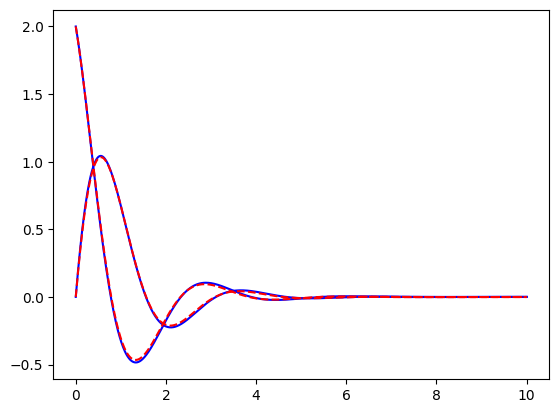

In [18]:
pred_y = odeint(func, true_y0, times)
plt.plot(times.cpu().squeeze(),true_y.cpu().squeeze(),color="blue")
plt.plot(times.cpu().squeeze(),pred_y.detach().numpy().squeeze(),'--',  color="red")

## Increase batch time

In [9]:
torch.manual_seed(0)
func = ODEFunc().to(device)
optimizer = optim.RMSprop(func.parameters(), lr=1e-2)

history = {}
history["losses"] = []
history["params"] = [k.detach().numpy() for k in list(func.parameters())]
history["gradients"] = []


for itr in tqdm(range(1, 1000)):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(func,batch_size=5, batch_time=100)
    pred_y = odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))#/torch.sum(torch.abs(batch_y)))
    loss.backward()
    optimizer.step()

    if itr % 10 == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, times)
            loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            history["losses"].append(loss.item())
            history["params"].append([k.detach().numpy() for k in list(func.parameters())])
            history["gradients"].append([k.grad for k in list(func.parameters())])
    end = time.time()


  1%|█▌                                                                                                          | 14/999 [00:00<00:50, 19.57it/s]

Iter 0010 | Total Loss 1.855860


  2%|██▍                                                                                                         | 22/999 [00:01<00:55, 17.54it/s]

Iter 0020 | Total Loss 1.744108


  3%|███▋                                                                                                        | 34/999 [00:01<00:56, 16.94it/s]

Iter 0030 | Total Loss 1.131447


  4%|████▋                                                                                                       | 43/999 [00:02<01:03, 15.16it/s]

Iter 0040 | Total Loss 1.242633


  5%|█████▌                                                                                                      | 52/999 [00:03<00:59, 15.85it/s]

Iter 0050 | Total Loss 1.090827


  6%|██████▋                                                                                                     | 62/999 [00:03<01:02, 14.87it/s]

Iter 0060 | Total Loss 0.851146


  7%|████████                                                                                                    | 74/999 [00:04<01:00, 15.21it/s]

Iter 0070 | Total Loss 0.850031


  8%|████████▉                                                                                                   | 83/999 [00:05<00:56, 16.15it/s]

Iter 0080 | Total Loss 0.860096


  9%|█████████▊                                                                                                  | 91/999 [00:05<01:10, 12.87it/s]

Iter 0090 | Total Loss 0.868335


 10%|███████████                                                                                                | 103/999 [00:06<00:58, 15.44it/s]

Iter 0100 | Total Loss 0.735251


 11%|████████████                                                                                               | 113/999 [00:07<01:08, 12.94it/s]

Iter 0110 | Total Loss 0.661041


 12%|█████████████▏                                                                                             | 123/999 [00:07<01:04, 13.52it/s]

Iter 0120 | Total Loss 0.591342


 13%|██████████████▏                                                                                            | 133/999 [00:08<01:05, 13.18it/s]

Iter 0130 | Total Loss 0.564037


 14%|███████████████▎                                                                                           | 143/999 [00:09<01:09, 12.36it/s]

Iter 0140 | Total Loss 0.415458


 15%|████████████████▍                                                                                          | 153/999 [00:10<01:07, 12.61it/s]

Iter 0150 | Total Loss 0.499968


 16%|█████████████████▌                                                                                         | 164/999 [00:10<01:00, 13.77it/s]

Iter 0160 | Total Loss 0.487501


 17%|██████████████████▍                                                                                        | 172/999 [00:11<01:02, 13.29it/s]

Iter 0170 | Total Loss 0.487776


 18%|███████████████████▍                                                                                       | 182/999 [00:12<01:07, 12.10it/s]

Iter 0180 | Total Loss 0.388856


 19%|████████████████████▌                                                                                      | 192/999 [00:13<01:06, 12.06it/s]

Iter 0190 | Total Loss 0.396685


 20%|█████████████████████▋                                                                                     | 202/999 [00:13<00:57, 13.78it/s]

Iter 0200 | Total Loss 0.399762


 21%|██████████████████████▊                                                                                    | 213/999 [00:14<00:57, 13.66it/s]

Iter 0210 | Total Loss 0.379192


 22%|███████████████████████▊                                                                                   | 222/999 [00:15<00:57, 13.45it/s]

Iter 0220 | Total Loss 0.349751


 23%|████████████████████████▊                                                                                  | 232/999 [00:15<01:02, 12.35it/s]

Iter 0230 | Total Loss 0.256402


 24%|█████████████████████████▊                                                                                 | 241/999 [00:16<00:58, 13.04it/s]

Iter 0240 | Total Loss 0.293561


 25%|██████████████████████████▉                                                                                | 252/999 [00:17<00:54, 13.75it/s]

Iter 0250 | Total Loss 0.287934


 26%|████████████████████████████                                                                               | 262/999 [00:18<00:51, 14.23it/s]

Iter 0260 | Total Loss 0.277644


 27%|█████████████████████████████▏                                                                             | 272/999 [00:18<01:00, 12.01it/s]

Iter 0270 | Total Loss 0.215634


 28%|██████████████████████████████▎                                                                            | 283/999 [00:19<00:50, 14.10it/s]

Iter 0280 | Total Loss 0.245350


 29%|███████████████████████████████▏                                                                           | 291/999 [00:20<01:02, 11.29it/s]

Iter 0290 | Total Loss 0.238722


 30%|████████████████████████████████▏                                                                          | 301/999 [00:21<01:01, 11.34it/s]

Iter 0300 | Total Loss 0.189275


 31%|█████████████████████████████████▎                                                                         | 311/999 [00:21<01:06, 10.29it/s]

Iter 0310 | Total Loss 0.186211


 32%|██████████████████████████████████▍                                                                        | 321/999 [00:23<01:18,  8.68it/s]

Iter 0320 | Total Loss 0.155932


 33%|███████████████████████████████████▍                                                                       | 331/999 [00:23<01:05, 10.20it/s]

Iter 0330 | Total Loss 0.164026


 34%|████████████████████████████████████▌                                                                      | 341/999 [00:24<01:09,  9.48it/s]

Iter 0340 | Total Loss 0.135220


 35%|█████████████████████████████████████▌                                                                     | 351/999 [00:25<01:10,  9.22it/s]

Iter 0350 | Total Loss 0.136023


 36%|██████████████████████████████████████▊                                                                    | 362/999 [00:27<01:21,  7.79it/s]

Iter 0360 | Total Loss 0.132793


 37%|███████████████████████████████████████▊                                                                   | 372/999 [00:27<00:59, 10.55it/s]

Iter 0370 | Total Loss 0.137589


 38%|████████████████████████████████████████▉                                                                  | 382/999 [00:28<00:56, 10.90it/s]

Iter 0380 | Total Loss 0.154229


 39%|██████████████████████████████████████████                                                                 | 393/999 [00:29<00:46, 13.04it/s]

Iter 0390 | Total Loss 0.143186


 40%|██████████████████████████████████████████▉                                                                | 401/999 [00:30<01:00,  9.92it/s]

Iter 0400 | Total Loss 0.133273


 41%|████████████████████████████████████████████▏                                                              | 413/999 [00:31<00:59,  9.89it/s]

Iter 0410 | Total Loss 0.143485


 42%|█████████████████████████████████████████████                                                              | 421/999 [00:32<00:52, 10.99it/s]

Iter 0420 | Total Loss 0.128513


 43%|██████████████████████████████████████████████▍                                                            | 433/999 [00:33<00:41, 13.65it/s]

Iter 0430 | Total Loss 0.129028


 44%|███████████████████████████████████████████████▏                                                           | 440/999 [00:33<00:49, 11.18it/s]

Iter 0440 | Total Loss 0.128510


 45%|████████████████████████████████████████████████▎                                                          | 451/999 [00:34<00:58,  9.32it/s]

Iter 0450 | Total Loss 0.133072


 46%|█████████████████████████████████████████████████▍                                                         | 461/999 [00:35<00:58,  9.20it/s]

Iter 0460 | Total Loss 0.127656


 47%|██████████████████████████████████████████████████▋                                                        | 473/999 [00:36<00:45, 11.67it/s]

Iter 0470 | Total Loss 0.133781


 48%|███████████████████████████████████████████████████▋                                                       | 483/999 [00:37<00:42, 12.04it/s]

Iter 0480 | Total Loss 0.126452


 49%|████████████████████████████████████████████████████▋                                                      | 492/999 [00:38<00:41, 12.16it/s]

Iter 0490 | Total Loss 0.133814


 50%|█████████████████████████████████████████████████████▌                                                     | 500/999 [00:39<00:48, 10.22it/s]

Iter 0500 | Total Loss 0.137654


 51%|██████████████████████████████████████████████████████▊                                                    | 512/999 [00:40<00:43, 11.23it/s]

Iter 0510 | Total Loss 0.134312


 52%|███████████████████████████████████████████████████████▉                                                   | 522/999 [00:41<00:47, 10.04it/s]

Iter 0520 | Total Loss 0.124099


 53%|█████████████████████████████████████████████████████████                                                  | 533/999 [00:42<00:36, 12.86it/s]

Iter 0530 | Total Loss 0.129896


 54%|██████████████████████████████████████████████████████████▎                                                | 544/999 [00:42<00:32, 13.95it/s]

Iter 0540 | Total Loss 0.141720


 55%|███████████████████████████████████████████████████████████▏                                               | 553/999 [00:43<00:35, 12.73it/s]

Iter 0550 | Total Loss 0.133218


 56%|████████████████████████████████████████████████████████████▎                                              | 563/999 [00:44<00:35, 12.43it/s]

Iter 0560 | Total Loss 0.119749


 57%|█████████████████████████████████████████████████████████████▏                                             | 571/999 [00:45<00:42, 10.02it/s]

Iter 0570 | Total Loss 0.122403


 58%|██████████████████████████████████████████████████████████████▏                                            | 581/999 [00:46<00:44,  9.33it/s]

Iter 0580 | Total Loss 0.120776


 59%|███████████████████████████████████████████████████████████████▎                                           | 591/999 [00:47<00:42,  9.51it/s]

Iter 0590 | Total Loss 0.124013


 60%|████████████████████████████████████████████████████████████████▌                                          | 603/999 [00:48<00:36, 10.72it/s]

Iter 0600 | Total Loss 0.137924


 61%|█████████████████████████████████████████████████████████████████▍                                         | 611/999 [00:48<00:38, 10.14it/s]

Iter 0610 | Total Loss 0.124979


 62%|██████████████████████████████████████████████████████████████████▌                                        | 621/999 [00:49<00:43,  8.66it/s]

Iter 0620 | Total Loss 0.137540


 63%|███████████████████████████████████████████████████████████████████▌                                       | 631/999 [00:50<00:38,  9.44it/s]

Iter 0630 | Total Loss 0.138612


 64%|████████████████████████████████████████████████████████████████████▋                                      | 641/999 [00:51<00:34, 10.23it/s]

Iter 0640 | Total Loss 0.119480


 65%|█████████████████████████████████████████████████████████████████████▊                                     | 652/999 [00:52<00:32, 10.60it/s]

Iter 0650 | Total Loss 0.122757


 66%|███████████████████████████████████████████████████████████████████████                                    | 663/999 [00:53<00:26, 12.75it/s]

Iter 0660 | Total Loss 0.118840


 67%|███████████████████████████████████████████████████████████████████████▊                                   | 671/999 [00:54<00:29, 11.00it/s]

Iter 0670 | Total Loss 0.120743


 68%|████████████████████████████████████████████████████████████████████████▉                                  | 681/999 [00:55<00:37,  8.40it/s]

Iter 0680 | Total Loss 0.133388


 69%|█████████████████████████████████████████████████████████████████████████▉                                 | 690/999 [00:56<00:33,  9.25it/s]

Iter 0690 | Total Loss 0.127388


 70%|███████████████████████████████████████████████████████████████████████████▏                               | 702/999 [00:57<00:28, 10.49it/s]

Iter 0700 | Total Loss 0.118609


 71%|████████████████████████████████████████████████████████████████████████████▏                              | 711/999 [00:57<00:23, 12.11it/s]

Iter 0710 | Total Loss 0.124262


 72%|█████████████████████████████████████████████████████████████████████████████▎                             | 722/999 [00:58<00:24, 11.36it/s]

Iter 0720 | Total Loss 0.137310


 73%|██████████████████████████████████████████████████████████████████████████████▏                            | 730/999 [00:59<00:24, 10.86it/s]

Iter 0730 | Total Loss 0.145121


 74%|███████████████████████████████████████████████████████████████████████████████▍                           | 742/999 [01:00<00:21, 12.09it/s]

Iter 0740 | Total Loss 0.143406


 75%|████████████████████████████████████████████████████████████████████████████████▋                          | 753/999 [01:01<00:19, 12.45it/s]

Iter 0750 | Total Loss 0.138369


 76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 761/999 [01:02<00:22, 10.42it/s]

Iter 0760 | Total Loss 0.124151


 77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 771/999 [01:02<00:24,  9.19it/s]

Iter 0770 | Total Loss 0.125058


 78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 783/999 [01:04<00:19, 11.01it/s]

Iter 0780 | Total Loss 0.137985


 79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 791/999 [01:04<00:21,  9.73it/s]

Iter 0790 | Total Loss 0.128256


 80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 802/999 [01:05<00:19,  9.98it/s]

Iter 0800 | Total Loss 0.119260


 81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 811/999 [01:06<00:17, 10.91it/s]

Iter 0810 | Total Loss 0.120409


 82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 821/999 [01:07<00:19,  9.23it/s]

Iter 0820 | Total Loss 0.137263


 83%|█████████████████████████████████████████████████████████████████████████████████████████                  | 832/999 [01:08<00:14, 11.46it/s]

Iter 0830 | Total Loss 0.135298


 84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 840/999 [01:09<00:17,  9.24it/s]

Iter 0840 | Total Loss 0.126463


 85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 852/999 [01:10<00:12, 11.82it/s]

Iter 0850 | Total Loss 0.140321


 86%|████████████████████████████████████████████████████████████████████████████████████████████               | 860/999 [01:11<00:14,  9.49it/s]

Iter 0860 | Total Loss 0.125268


 87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 871/999 [01:12<00:15,  8.47it/s]

Iter 0870 | Total Loss 0.131295


 88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 882/999 [01:13<00:10, 10.68it/s]

Iter 0880 | Total Loss 0.132248


 89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 893/999 [01:14<00:08, 12.03it/s]

Iter 0890 | Total Loss 0.132104


 90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 902/999 [01:14<00:08, 11.07it/s]

Iter 0900 | Total Loss 0.130145


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▌         | 911/999 [01:15<00:08, 10.20it/s]

Iter 0910 | Total Loss 0.122326


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 921/999 [01:16<00:10,  7.62it/s]

Iter 0920 | Total Loss 0.130030


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 931/999 [01:17<00:07,  9.20it/s]

Iter 0930 | Total Loss 0.118756


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 943/999 [01:18<00:04, 13.04it/s]

Iter 0940 | Total Loss 0.122199


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 953/999 [01:19<00:03, 13.19it/s]

Iter 0950 | Total Loss 0.137685


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 963/999 [01:20<00:02, 13.77it/s]

Iter 0960 | Total Loss 0.136773


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████   | 971/999 [01:21<00:02, 10.53it/s]

Iter 0970 | Total Loss 0.117325


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 982/999 [01:21<00:01, 12.10it/s]

Iter 0980 | Total Loss 0.121954


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 991/999 [01:23<00:00,  8.06it/s]

Iter 0990 | Total Loss 0.131180


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [01:23<00:00, 11.94it/s]


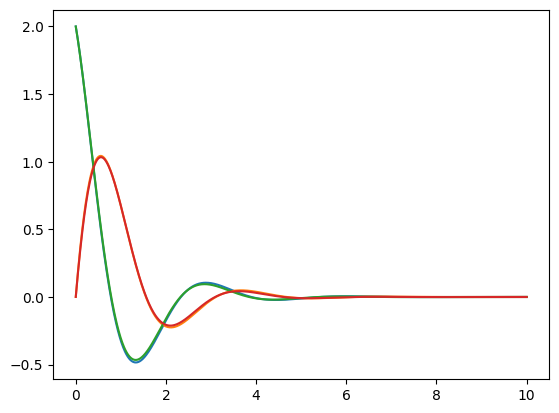

In [17]:
pred_y = odeint(func, true_y0, times)
plt.plot(times.cpu().squeeze(),true_y.cpu().squeeze())
plt.plot(times.cpu().squeeze(),pred_y.detach().numpy().squeeze())